# Load Packages

In [1]:
using Dates, DelimitedFiles, Statistics, LinearAlgebra, StatsBase, HDF5

include("jlFiles/printmat.jl")

printlnPs (generic function with 2 methods)

In [2]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

# Loading Daily S&P 500 Data

In [3]:
x  = readdlm("Data/SP500RfPs.csv",',',skipstart=1)
SP = convert(Array{Float64},x[:,2])       #convert to numerical array, S&P 500 level
R  = (SP[2:end]./SP[1:end-1] .- 1) * 100  #returns, % 
T  = length(R)  

dN = Date.(string.(x[2:end,1]),"d/m/y")    #convert to Date, 2:end as for R
println("Number of days in the sample: ",T)

Number of days in the sample: 9352


# Autocorrelations

$\rho_s = \text{Corr}(R_t,R_{t-s})$

In large samples, $\sqrt{T}\hat{\rho}_{s}\sim N(0,1)$, if the true value is $\rho_s=0$ for all $s$

In [4]:
plags = 1:5
ρ = autocor(R,plags)
println("\n   lag      autocorrr  t-stat(autocorr)")
printmat([plags ρ sqrt(T)*ρ])


   lag      autocorrr  t-stat(autocorr)
     1.000    -0.026    -2.480
     2.000    -0.044    -4.208
     3.000    -0.007    -0.684
     4.000    -0.022    -2.124
     5.000    -0.018    -1.744



# Autoregressions

An AR(1) is 

$R_{t}=c+a_{1}R_{t-1}+\varepsilon_{t}$

and can be estimated by OLS

An asymmteric AR(1) 

$R_{t} =\alpha+\beta Q_{t-1}R_{t-1}+\gamma(1-Q_{t-1})R_{t-1}+\varepsilon
_{t}$,

where $Q_{t-1}=1 \ \text{ if } \ R_{t-1}<0$ and zero otherwise

In [5]:
function OlsFn(y,x)                      #OLS estimation, alternative: use GLM.jl 
    b     = x\y
    yhat  = x*b
    res   = y - yhat
    Covres = cov(res)
    Covb   = kron(Covres,inv(x'x))       #works also if y is Txn
    R2a    = 1 .- var(res,dims=1)./var(y,dims=1)
    return b,res,yhat,Covb,R2a            #the outputs
end

OlsFn (generic function with 1 method)

In [6]:
y  = R[2:end]
Tb = size(y,1)
x  = [ones(Tb) R[1:end-1]]
(b,res,yhat,Covb,) = OlsFn(y,x) 
Stdb  = sqrt.(diag(Covb))
tstat = b./Stdb 

println("Results from AR(1): intercept and slope")
println("Coefficient   t-stat")
printmat([b tstat])

Results from AR(1): intercept and slope
Coefficient   t-stat
     0.039     3.405
    -0.026    -2.481



In [7]:
Q = R[1:end-1] .< 0

x = [ones(Tb) Q.*R[1:end-1] (1.0.-Q).*R[1:end-1]]

(b,res,yhat,Covb,) = OlsFn(y,x) 
Stdb  = sqrt.(diag(Covb))
tstat = b./Stdb 

println("Results from AR(1) with dummies: [intercept, slope neg, slope pos]")
println("Coefficient   t-stat")
printmat([b tstat])

Results from AR(1) with dummies: [intercept, slope neg, slope pos]
Coefficient   t-stat
     0.001     0.058
    -0.075    -4.395
     0.027     1.518



## Recursive Estimation and Out-of-Sample R2

Do recursive estimation (longer and longer sample) an predict one period ahead (outside of the sample). Define an "out-of-sample" $R^2$ as 

$R_{OS}^2 = 1- \frac{\text{MSE(forecasting model)}}{\text{MSE(benchmark forecast)}}$

In [8]:
y  = R[2:end]
Tb = size(y,1)
x  = [ones(Tb) Q.*R[1:end-1] (1.0.-Q).*R[1:end-1]]

(ϵ,e) = (zeros(Tb),zeros(Tb))
for t = 100:Tb
    local b
    b,        = OlsFn(y[1:t-1],x[1:t-1,:]) 
    ϵ[t]      = y[t] - x[t,:]'b         #forecast error, model
    e[t]      = y[t] - mean(y[1:t-1])   #forecast error, historical average
end    
(ϵ,e) = (ϵ[100:end],e[100:end])

MSE_Model = mean(ϵ.^2)    #MSE for out-of-sample period
MSE_Bench = mean(e.^2)

printlnPs("MSE of AR(1) model and the benchmark: ",[MSE_Model MSE_Bench])
printlnPs("out-of-sample R2: ",1-MSE_Model/MSE_Bench)

MSE of AR(1) model and the benchmark:      1.253     1.244
out-of-sample R2:     -0.007


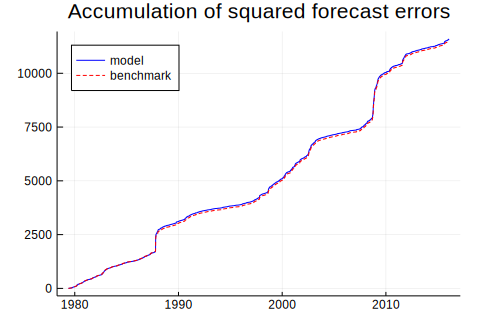

In [9]:
xTicksLoc = Dates.value.([Date(1980);Date(1990);Date(2000);Date(2010)])
xTicksLab = ["1980";"1990";"2000";"2010"]     

p1 = plot(dN[101:end],cumsum(ϵ.^2),color=:blue,label="model")
plot!(dN[101:end],cumsum(e.^2),color=:red,label="benchmark",line=:dash,legend=:topleft)
plot!(xticks=(xTicksLoc,xTicksLab))
title!("Accumulation of squared forecast errors")

## Mariano-Diebold and Clark-West Tests (extra)

The Mariano-Diebold and Clark-West tests compares the prediction errors of two models ($e$: baseline model and $\epsilon$: your model). Notice that MD test is not well suited for nested model (your model is an augmented version of the baseline model). Use the Clark-West in that case.

In [10]:
function MDCW(e,ϵ)
      g = hcat(e.^2 - ϵ.^2,       #Mariano-Diebold
               2*e.*(e - ϵ))      #Clark&West
  return g
end

MDCW (generic function with 1 method)

In [11]:
g = MDCW(e,ϵ)            
Tg = size(g,1) 

μ      = mean(g,dims=1)
Stdμ   = std(g,dims=1)/sqrt(Tg)
tstats = μ./Stdμ

println("t-stats for Mariano-Diebold and Clark_West test")
printmat(tstats)

t-stats for Mariano-Diebold and Clark_West test
    -0.645     0.283



# A Trading Strategy

This section implements a momentum strategy (buy past winners, short sell past losers), and rebalance daily. (For simplicity, we disregard trading costs.)

## Load Data

The data is in a HDF5 file which stores data in a format used by many languages.
The data set contains daily data for "dates", the equity market return, riskfree rate and the the returns of the 25 Fama-French portfolios. All returns are in percent.

In [12]:
using HDF5                       #to read hdf5 files, a very common data format
fh = h5open("Data/MomentumSR.h5","r")   #open for reading
  (ymd,Rm,Rf,R) = read(fh,"Data/ymd","Data/Rm","Data/Rf","Data/R")
close(fh)
dN = Date.(ymd[:,1],ymd[:,2],ymd[:,3])       #2001,12,31 to julia date

println("\nThe first few rows of dN, Rm and Rf")
printmat([dN[1:4] Rm[1:4] Rf[1:4]])

println("size of dN, Rm, Rf, R")
println(size(dN),"\n",size(Rm),"\n",size(Rf),"\n",size(R))

(T,n) = size(R)                      #number of periods and assets

println()


The first few rows of dN, Rm and Rf
1979-01-02     0.615     0.035
1979-01-03     1.155     0.035
1979-01-04     0.975     0.035
1979-01-05     0.685     0.035

size of dN, Rm, Rf, R
(9837,)
(9837,)
(9837,)
(9837, 25)



## Implementing the Strategy

1.  In period  $t$ , sort  $R_t$  across the 25 assets.
2. (In the evening of) period  $t$  buy 1/5 of each of the 5 best assets based on the sort in point 1. Similarly, buy -1/5 (short-sell) each of the 5 worst assets. Collect these portfolio weights in a vector $w_{t+1}$
3. In period  $t+1$ , the return on the portfolio is $Rp_{t+1}=w′_{t+1}R_{t+1}$.
4. Repeat for all periods

In [13]:
Rp = fill(NaN,T)              
for t = 2:T         #loop over periods, save portfolio returns
    local sort1, w
    sort1                = sortperm(R[t-1,:])        
    w                    = zeros(n)
    w[sort1[1:5]]       .= -1/5
    w[sort1[end-4:end]] .= 1/5
    Rp[t]                = w'R[t,:]
end
Rp = Rp[2:end]                   #cut out t=1

println()

Calculate the mean (excess) return, its standard deviation and the Sharpe ratio. Annualize by assuming 250 trading days per year. Compare with the excess return on passively holding an equity market index.

In [14]:
μ = mean(Rp)
σ = std(Rp)
printlnPs("mean, std and SR of strategy ",μ*250,σ*sqrt(250),μ/σ*sqrt(250))

Rme = Rm - Rf
μm  = mean(Rme[2:end])
σm  = std(Rme[2:end])
printlnPs("mean, std and SR of market   ",μm*250,σm*sqrt(250),μm/σm*sqrt(250))

mean, std and SR of strategy     16.134     9.871     1.634
mean, std and SR of market        8.307    16.770     0.495
